In [1]:
import json
import os
import PIL
import PIL.Image
from IPython.display import display
from PIL import Image
import random

import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import all the Keras machinery we need
from keras import applications
from keras import optimizers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import metrics


print('ko')

Using TensorFlow backend.


ko


In [2]:
DATA_DIR = '/home/abert/Documents/NumeriCube/eurosilicone/angle/ds/ds_rotated/'

In [3]:

HEIGHT = 224
WIDTH = 224
batch_size = 4


# data generator for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255) 

# data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./255)

# generator for reading train data from folder
train_generator = train_datagen.flow_from_directory(
    DATA_DIR+'train',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical')

# generator for reading validation data from folder
validation_generator = test_datagen.flow_from_directory(
    DATA_DIR+'val',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical')

# generator for reading test data from folder
test_generator = test_datagen.flow_from_directory(
    DATA_DIR+'test',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False)

Found 2520 images belonging to 360 classes.
Found 1440 images belonging to 360 classes.
Found 360 images belonging to 360 classes.


In [4]:
train_generator.class_indices


{'0': 0,
 '1': 1,
 '10': 2,
 '100': 3,
 '101': 4,
 '102': 5,
 '103': 6,
 '104': 7,
 '105': 8,
 '106': 9,
 '107': 10,
 '108': 11,
 '109': 12,
 '11': 13,
 '110': 14,
 '111': 15,
 '112': 16,
 '113': 17,
 '114': 18,
 '115': 19,
 '116': 20,
 '117': 21,
 '118': 22,
 '119': 23,
 '12': 24,
 '120': 25,
 '121': 26,
 '122': 27,
 '123': 28,
 '124': 29,
 '125': 30,
 '126': 31,
 '127': 32,
 '128': 33,
 '129': 34,
 '13': 35,
 '130': 36,
 '131': 37,
 '132': 38,
 '133': 39,
 '134': 40,
 '135': 41,
 '136': 42,
 '137': 43,
 '138': 44,
 '139': 45,
 '14': 46,
 '140': 47,
 '141': 48,
 '142': 49,
 '143': 50,
 '144': 51,
 '145': 52,
 '146': 53,
 '147': 54,
 '148': 55,
 '149': 56,
 '15': 57,
 '150': 58,
 '151': 59,
 '152': 60,
 '153': 61,
 '154': 62,
 '155': 63,
 '156': 64,
 '157': 65,
 '158': 66,
 '159': 67,
 '16': 68,
 '160': 69,
 '161': 70,
 '162': 71,
 '163': 72,
 '164': 73,
 '165': 74,
 '166': 75,
 '167': 76,
 '168': 77,
 '169': 78,
 '17': 79,
 '170': 80,
 '171': 81,
 '172': 82,
 '173': 83,
 '174': 84,
 '

In [5]:
def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)

def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    diff = angle_difference(K.argmax(y_true), K.argmax(y_pred))
    print(K.argmax(y_true), K.argmax(y_pred))
    return K.mean(K.cast(K.abs(diff), K.floatx()))

In [10]:
# SOLUTION 3 InceptionV3 simple sans préentrainement du top classifier
from keras.optimizers import Adam, SGD, Adadelta
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model


model_name = 'rotnet_chip_resnet50'

# number of classes
nb_classes = 360
# input image shape
input_shape = (224, 224, 3)

# load base model
base_model = ResNet50(weights='imagenet', include_top=False,
                  input_shape=input_shape)

# append classification layer
x = base_model.output
x = Flatten()(x)
final_output = Dense(nb_classes, activation='softmax', name='fc360')(x)

# create the new model
model = Model(inputs=base_model.input, outputs=final_output)

model.summary()

# model compilation
model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr = 1e-3),
          metrics=[angle_error])




'''

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:10]:
    layer.trainable = False
    
'''

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

'\n\n# set the first 25 layers (up to the last conv block)\n# to non-trainable (weights will not be updated)\nfor layer in model.layers[:10]:\n    layer.trainable = False\n    \n'

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from time import time


# training parameters
batch_size = 4
nb_epoch = 100
n_train_samples = 2520
n_val_samples = 1440


output_folder = '../models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
monitor = 'val_angle_error'
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    monitor=monitor,
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(monitor=monitor, factor = 0.3, patience=3)
early_stopping = EarlyStopping(monitor=monitor, patience=5)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

#K.clear_session()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train_samples // batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=n_val_samples // batch_size,
    callbacks=[checkpointer, tensorboard])

Epoch 1/100
630/630 [==============================] - 290s 460ms/step - loss: 11.0733 - angle_error: 83.6706 - val_loss: 5.8958 - val_angle_error: 89.8299
Epoch 2/100
630/630 [==============================] - 282s 448ms/step - loss: 8.6617 - angle_error: 87.8647 - val_loss: 5.8950 - val_angle_error: 90.6847
Epoch 3/100
630/630 [==============================] - 283s 449ms/step - loss: 6.3196 - angle_error: 88.3246 - val_loss: 8.3017 - val_angle_error: 86.6965
Epoch 4/100
630/630 [==============================] - 284s 450ms/step - loss: 6.8538 - angle_error: 89.7560 - val_loss: 9.9480 - val_angle_error: 84.4813
Epoch 5/100
285/630 [============>.................] - ETA: 2:19 - loss: 7.5396 - angle_error: 79.3623

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
0.89


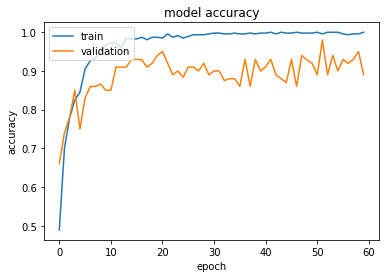

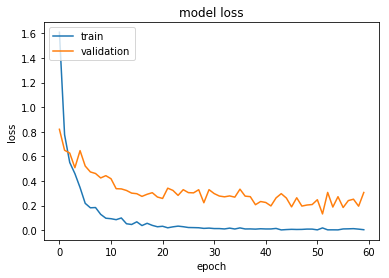

In [7]:
model.save('resnet_v1.h5')
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
print(history.history['val_acc'][-1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Avec K-Fold CROSS VALIDATION ( a faire)
'''
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    model.fit_generator(
                train_generator,
                steps_per_epoch=n_train_samples // batch_size,
                epochs=6,
                validation_data=validation_generator,
                validation_steps=n_val_samples // batch_size,
)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
# Leeeet's traaaaaaaaiiiiin!!!!
'''

'\nfor j, (train_idx, val_idx) in enumerate(folds):\n    \n    print(\'\nFold \',j)\n    X_train_cv = X_train[train_idx]\n    y_train_cv = y_train[train_idx]\n    X_valid_cv = X_train[val_idx]\n    y_valid_cv= y_train[val_idx]\n    \n    name_weights = "final_model_fold" + str(j) + "_weights.h5"\n    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)\n    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)\n    model = get_model()\n    model.fit_generator(\n                generator,\n                steps_per_epoch=len(X_train_cv)/batch_size,\n                epochs=15,\n                shuffle=True,\n                verbose=1,\n                validation_data = (X_valid_cv, y_valid_cv),\n                callbacks = callbacks)\n    \n    model.fit_generator(\n                train_generator,\n                steps_per_epoch=n_train_samples // batch_size,\n                epochs=6,\n                validation_data=validation_generator,\n           

In [12]:

#Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)
#validation_generator.classes
#y_pred
n_correct = 0
#import pdb;pdb.set_trace()
for _val_xs, _val_ys in validation_generator:#n_validation_samples // batch_size):
    for idx in range(len(_val_ys)):
        img = _val_xs[idx]
        _y = np.argmax(_val_ys[idx], axis=0)
        pred = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=1)
        print(_y, pred, pred == _y)
#        n_correct += pred == _y and 1 or 0
#print("Correct answers = %0.2f%%" % (n_correct / len(validation_generator.classes) * 100))

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] 

2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] 

0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] 

0 [1] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] 

0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

0 [0] [ True]
2 [1] [False]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] 

0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] 

0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [1] [False]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [1] [False]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] 

KeyboardInterrupt: 

In [8]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


def evaluate(X_test, y_test):
    TEST_DIR =  "./dataset_split/test"
    HEIGHT = 224
    WIDTH = 224
    BATCH_SIZE = 16

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    test_info = {'id':X_test,'label':y_test}

    testdf = pd.DataFrame(test_info)


    test_generator=test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="./dataset_split/test/",
        x_col="id",
        y_col="label",
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode="categorical",
        target_size=(HEIGHT,WIDTH))
        
        
    model = load_model('resnet_v1.h5')

    
    probabilities = model.predict_generator(test_generator, len(test_generator))


    #y_pred = np.rint(probabilities)
    y_true = test_generator.classes

    y_test = probabilities.argmax(axis=-1)

    print(confusion_matrix(y_true, y_test))

    acc = accuracy_score(y_true, y_test)
    print(acc)

    
evaluate(X_test, y_test)

Found 145 images belonging to 3 classes.
[[26  0  1]
 [ 0 55  4]
 [ 0  7 52]]
0.9172413793103448


In [23]:
'''

#from keras.models import load_model
#from sklearn.metrics import confusion_matrix
#import matplotlib
#import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          ):
    """
    This function prints and plots the confusion matrix.
    """
    
    cmap = plt.cm.jet
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
cnnmodel = load_model('vgg16_v3.h5')
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_labels))

# Sample prediction
for idx in range(10):
    img = image.load_img(X[idx], target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = cnnmodel.predict(x)
    print(X[idx], list(target_labels).index(y[idx]), np.argmax(pred), pred)
    
# Plot a pretty confusion matrix
np.set_printoptions(precision=2)
dev_feats = read_dataset('valid')
predictions = emotion_classifier.predict_classes(dev_feats)
te_labels = get_labels('valid')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)


plt.figure()
plot_confusion_matrix(conf_mat, classes=target_labels)
plt.show()
'''

NameError: name 'CATEGORIES' is not defined

In [11]:
from keras.models import load_model
import numpy as np
from keras.preprocessing import image
import time





def classify(im_name):
    
    #model = load_model('model_gl_pl.h5')

    HEIGHT = 224
    WIDTH = 224


    # If you wish to test images, please put them in the same folder as the programm
    
    # Image preparation 
    img = image.load_img(im_name, target_size=(HEIGHT, WIDTH)) #resize
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)# correct shape for classification
    im_ready = np.vstack([x])

    classe = model.predict(im_ready)
    classe =classe.argmax(axis = -1) #taking index of the maximum %
    return classe[0]






model = load_model('vgg16_v3.h5')
t_start = time.time()
print(classify('./dataset/wsEN4iv2SliFUuYNXIM-5Q_0AGdsJ3jTp-mb1Ew1tF-gg_320x200.png'))
t_end = time.time()
print(t_end-t_start)

2
0.30704712867736816
